## ION CHANNEL ASSAY DEVELOPMENT

by Anastasia Abashidze


Blavatnik Center for Drug Discovery
***

## Introduction

#### Assay Dvelopment

<div align="justify"> In assay development experiments, we do not screen many compounds, but we try diffrent treatments to figure out best settings for the screen. Accordingly, in the analysis, we have to split the readings by treatments and compare between them. </div>  

<div align="justify">The main purpose of this experiment is to check whether some of two compounds (Compound_1 or Compound_2) can serve as positive control in our ion channel assay. In addition, we found in previous experiments, that our assay is quite noisy, so here we add compound which supposed to block unspecific signal (synchronize the channels). Accordingly, in our plate we have two treatments: 'Block_0mM' (wells without blocking), and 'Block_1mM' for wells with blocking agent. Finally, DMSO serves us as negative control. </div>

#### Ion Channels

<div align="justify"> Ion channels regulate a wide range of physiological processes including rapid electrical signaling, fluid, hormone and transmitter secretion, and proliferation. As such, ion channels are common targets for therapeutics.   
Gating is the process by which an ion channel transitions between its open and closed states. When ion channels are in a 'closed' state, they are impermeable to ions and do not conduct electrical current. When ion channels are in their open state, they conduct electrical current by allowing specific types of ions to pass through them, and thus, across the plasma membrane of the cell. Some drugs and many ion channel toxins act as 'gating modifiers' by changing the kinetics of gating.</div> 



#### Thalium flux assay

<div align="justify"> Diagram of the thallium-flux assay for potassium channels, closed state, open state and the raw signal. For a potassium channel, the Tl+-flux assay is the most commonly used assay format. To trigger the channel to open, typically a high-K+ solution is used to depolarize the membrane potential. Then, thallium passes into the cells through open potassium channels. Upon the cytosolic thallium binding to the dye, the fluorescence signal is kinetically increased.</div>

<img style="float: left; margin-right:700px"  width="750" src="hts_images/thalium.png" > 

Taken from Yu, H., Li, M., Wang, W. et al, 2016. High throughput screening technologies for ion channels.   https://doi.org/10.1038/aps.2015.108

#### Normalization and Analysis

<div align="justify"> We will normalize fluorescence data by dividing the fluorescence values at each time point in each well by the average of that well’s first five time points (F/F0). In all instances, we will multiply the F/F0 value by average initial fluorescent values for all wells on the assay plate to arrive at “normalized fluorescence intensity”. 
Next, we will subtract the normalized values at each time point from the vehicle-control condition (DMSO) from the values obtained under the test compound conditions to reveal time-dependent, test condition-mediated changes in Tl+ flux. Tl+ flux data will be quantified by measuring the slope of the increase in fluorescence over a 10 s period beginning 2 s after the addition of Tl+ stimulus buffer. </div> 

#### References

* Gating: description (https://en.wikipedia.org/wiki/Gating_(electrophysiology))
* Assay Guidance Manual (https://www.ncbi.nlm.nih.gov/books/NBK100915/)
***

## The Workflow

[Import Packages and create Output Folder](#import)   
[Load Data](#load_data)      
[Nomalizing Fluorescence](#blank)   
[Create Time Series Table](#time_series)   
[Add Layout](#layout)   
[Split by Treatments and Plot](#split)    
[Get Slopes](#slopes)  

[Running QC](#qc) 
 - [Building Heatmap Function](#heatmap)
 - [Get Statistics](#stat)

[Plot Results](#viso)
 - [Point plot](#point)
 - [Violin plot](#violin)

[Conclusions](#viso)
 ***

### Import Packages and create Output Folder
<a id="import"></a>

In [1]:
from nbdev.showdoc import *
import os
import sys
sys.path.append('..//')
import pandas as pd
import numpy as np
from scipy import stats
import re
import matplotlib as mpl
%matplotlib inline
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context = 'notebook', style = 'white', palette = 'dark')
#%load_ext autoreload
#%autoreload 2
#hide
from simplydrug.core import *

#### Create folder to save the output

In [5]:
path = ('ion_channel_dev_output') 
if not os.path.exists(path):
    os.mkdir(path)
    print('Output folder created')

Output folder created


### Load Fluorescence Data
<a id="load_data"></a>

In [2]:
data_path = 'hts_data//ion_channel_dev_data.xlsx'
layout_path = 'hts_data//ion_channel_dev_layout.xlsx'

In [7]:
data = pd.DataFrame(pd.ExcelFile(data_path).parse(0))   
print('Data table size: ' + str(data.shape))
display(data.head())

Data table size: (240, 51)


,Well,0s,11s,22s,34s,45s,56s,67s,79s,90s,...,449s,461s,472s,483s,494s,506s,517s,528s,539s,550s
0,C3,6563,6482,6427,6619,6705,10982,13274,15686,17296,...,24679,25213,24791,25333,25080,25436,25650,25117,24960,25465
1,D3,5805,5477,5641,5797,5682,14824,18498,20397,22012,...,26538,26931,26609,26631,26987,26655,26895,26850,26992,26985
2,E3,5699,5656,5910,5784,5973,10632,13010,15067,16519,...,23466,23485,23251,23785,24047,24000,23685,23722,23977,23811
3,F3,5895,5890,5877,6006,5696,15156,17867,19462,20705,...,26229,25641,26398,26282,25967,26467,26204,26030,26596,26876
4,G3,5358,5591,5598,5421,5533,10725,12509,14194,15594,...,22842,22174,22887,22648,22348,22477,22987,22735,22733,23186


__Here we have 240 rows (wells) and 550 time points for ion channels.__

### Normalizing fluorescence
<a id="blank"></a>

We use blank to calibrate the assay (this is a method blank). We will take for blank values the measurements before the trigger was added  - in our case it is 5 first time points (0s -45s). We will ensure that we have acceptable variance between blank values using heatmap, and then we normalize well fluorescence as follows:


normalized_well = (raw_well / mean_blank_well) * plate_mean - plate_dmso


#### Blank heatmap

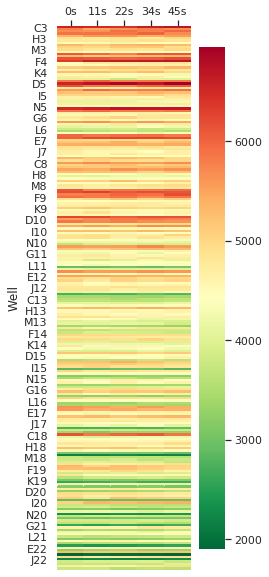

In [8]:
blank  = data[list(data)[:6]].set_index('Well')
plt.figure(figsize = (3,10))
r = sns.heatmap(blank.dropna(), cmap = 'RdYlGn_r')
r.xaxis.set_ticks_position('top')

#### Normalize fluorescence
* __Divide by blank and drop blank column__
* __Multiply by plate mean__
* __Calculate plate dmso (neative control)__
* __Subtract plate dmso__

In [9]:
# Divide by blank and drop blank column 
data['blank'] = blank.transpose().mean().values
data = data.set_index('Well').apply(lambda row: row/row['blank'], axis = 1).drop(columns = ['blank'])

# Multiply by plate mean
plate_means = data[list(data)].mean().values
data = data[list(data)].apply(lambda row: row*plate_means, axis = 1).reset_index(drop = False)

display(data.head(3))

,Well,0s,11s,22s,34s,45s,56s,67s,79s,90s,...,449s,461s,472s,483s,494s,506s,517s,528s,539s,550s
0,C3,0.999663,0.985489,0.980581,1.009273,1.025074,3.607374,4.972648,6.425106,7.540636,...,15.027543,15.391614,15.212260,15.627531,15.534779,15.823855,15.997200,15.684591,15.664468,16.005715
1,D3,1.020999,0.961518,0.993810,1.020685,1.003066,5.622728,8.001706,9.647313,11.081378,...,18.659524,18.983841,18.853856,18.969819,19.302080,19.147591,19.368684,19.360727,19.560416,19.585099
2,E3,0.980942,0.971730,1.018958,0.996640,1.031911,3.946555,5.507528,6.974104,8.138410,...,16.147044,16.201072,16.122592,16.580608,16.831856,16.872066,16.692583,16.739800,17.004327,16.912296


In [10]:
# Calculate plate dmso
layout = add_layout(data, layout_path, chem_path = None, chem_plate = None)
dmso = layout[layout.Compound_id == 'DMSO'].mean().values
# Subtract dmso
data = data.set_index('Well')
data  = data.apply(lambda row: row - dmso, axis = 1).reset_index(drop = False)

display(data.head())

Added  Well
Added  Status
Added  Compound_id
Added  Treatment
Chemical library not requested


,Well,0s,11s,22s,34s,45s,56s,67s,79s,90s,...,449s,461s,472s,483s,494s,506s,517s,528s,539s,550s
0,C3,0.002663,-0.005633,-0.020794,0.010219,0.013582,-0.883754,-0.823471,-0.491522,-0.300119,...,-1.728836,-1.514381,-1.921771,-1.692193,-1.951088,-1.827379,-1.811554,-2.121942,-2.422818,-2.134143
1,D3,0.023999,-0.029604,-0.007566,0.021631,-0.008426,1.131600,2.205588,2.730685,3.240623,...,1.903145,2.077846,1.719826,1.650095,1.816213,1.496356,1.559929,1.554195,1.473130,1.445242
2,E3,-0.016058,-0.019392,0.017582,-0.002414,0.020420,-0.544573,-0.288591,0.057476,0.297656,...,-0.609335,-0.704923,-1.011438,-0.739116,-0.654011,-0.779168,-1.116172,-1.066732,-1.082959,-1.227561
3,F3,0.005861,0.009025,0.000091,0.023785,-0.038897,1.069194,1.679432,1.986882,2.241164,...,1.081689,0.576373,0.957544,0.788165,0.478214,0.738433,0.444061,0.348008,0.554738,0.727092
4,G3,-0.023746,0.022567,0.017170,-0.013301,-0.002728,-0.289870,-0.207804,0.016757,0.266844,...,-0.169414,-0.763299,-0.386108,-0.658535,-0.978089,-0.975913,-0.712094,-0.875916,-1.073529,-0.760664


### Create Time Series Table
<a id="time_series"></a>

* __Transform seconds from string to integers__    
* __Create dataframe with columns 'Well', 'Time', and 'Value' (RFU)__   

In [11]:
data = data.set_index('Well')
data.columns = [int(time.replace('s', '')) for time in data.columns] # transform seconds

ts_data = pd.DataFrame()  # create dataframe
for index, row in data.iterrows():
    well_data = pd.DataFrame({'Well': index, 'Time': list(data), 'RFU': row})
    ts_data = ts_data.append(well_data)
    
print(ts_data.shape)
display(ts_data.head(3))

(12000, 3)


,Well,Time,RFU
0,C3,0,0.002663
11,C3,11,-0.005633
22,C3,22,-0.020794


### Add Layout
<a id="layout"></a> 

In [12]:
ts_data= add_layout(ts_data, layout_path, chem_path = None, chem_plate = None)
display(ts_data.head(3))

Added  Well
Added  Status
Added  Compound_id
Added  Treatment
Chemical library not requested


,Well,Time,RFU,Status,Compound_id,Treatment
0,C3,0,0.002663,Positive,Compound_1,Block_1mM
1,C3,11,-0.005633,Positive,Compound_1,Block_1mM
2,C3,22,-0.020794,Positive,Compound_1,Block_1mM


### Split by Treatments and Plot
<a id="split"></a> 
#### Print treatments and compounds

In [13]:
ts_data = ts_data.dropna(subset = ['Compound_id']) 
print('Treatments ', ts_data['Treatment'].unique())
print('Compounds ', ts_data['Compound_id'].unique())

Treatments  ['Block_1mM' 'Block_0mM']
Compounds  ['Compound_1' 'Compound_2' 'DMSO']


#### Split data into different dataframes  by treatments

In [14]:
block_1 = ts_data[ts_data['Treatment'] == 'Block_1mM']
block_0 = ts_data[ts_data['Treatment'] == 'Block_0mM']
block_1.name = 'Block_1mM'
block_0.name = 'Block_0mM'

#### Write functions to plot raw data and mean data

In [15]:
# function
def plot_curve_raw(x, y, units, hue, hue_order, df, xlabel, ylabel, xlimit, palette, save_as, path):
    ax = sns.lineplot(x, y, units = units, hue = hue, hue_order = hue_order, data = df, palette = palette, estimator = None)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xlim(0, xlimit)
    fig = ax.get_figure()
    fig.set_size_inches(10, 7)
    plt.savefig(path + '//' + save_as, bbox_inches = 'tight', dpi = 600)
    plt.show()
    plt.close()

In [16]:
# function
def plot_curve_mean(x, y, hue, hue_order, df, xlabel, ylabel, xlimit, palette, save_as, path):
    ax = sns.lineplot(x, y, hue = hue, hue_order = hue_order, data = df, palette = palette)
    sns.despine()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xlim(0, xlimit)
    fig = ax.get_figure()
    fig.set_size_inches(10, 7)
    plt.savefig(path + '//' + save_as, bbox_inches='tight', dpi=600)
    plt.show()

<div class="alert alert-block alert-info"><b>Tip:</b> in the mean plot, we set xlimit to 200 for better visualization.</div>

#### Defining palette

In [17]:
palette = {'DMSO':'Dodgerblue','Compound_1':'Darkred','Compound_2':'Darkgreen' }
hue_order = ['Compound_1', 'Compound_2', 'DMSO']

#### Plot treatments

Block_1mM


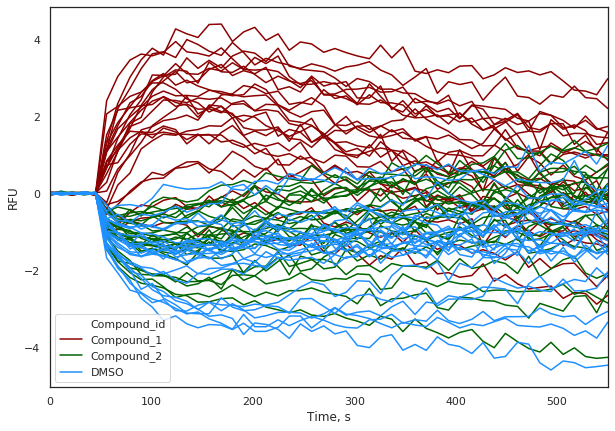

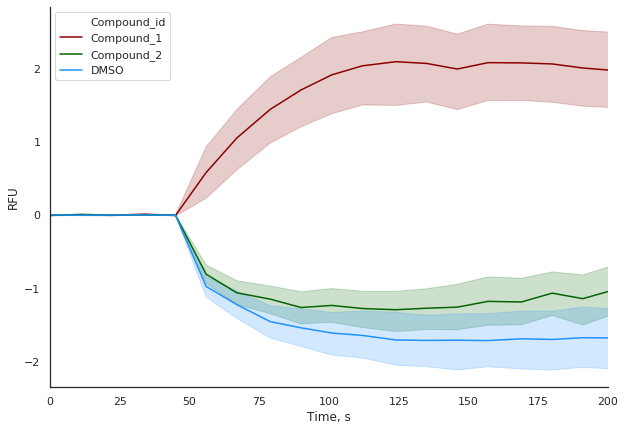

Block_0mM


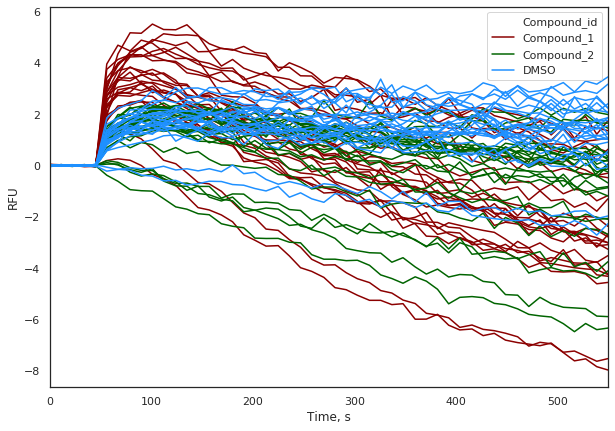

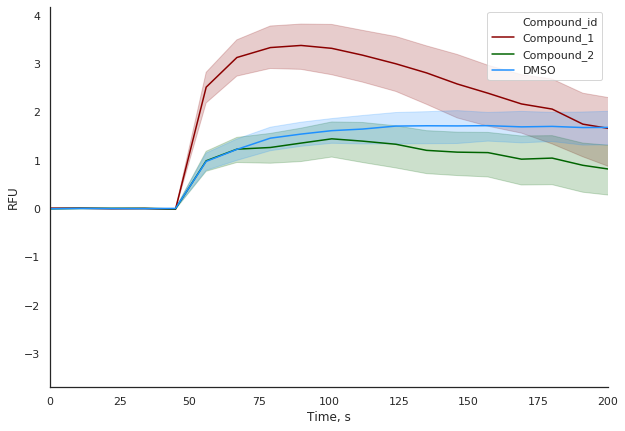

In [18]:
dataframes = [block_1, block_0]

for df in dataframes:
    print(df.name)
    
    plot_curve_raw(x = 'Time', y = 'RFU', units = 'Well', hue = 'Compound_id', hue_order = hue_order, df = df, 
                       ylabel = 'RFU', xlabel = 'Time, s', xlimit = 550, palette = palette, save_as = df.name + '_raw.png', path = path)
    
    plot_curve_mean(x = 'Time', y = 'RFU', hue = 'Compound_id', hue_order = hue_order, df = df, xlabel = 'Time, s', 
                       ylabel = 'RFU', xlimit = 200, palette = palette, save_as = df.name + '_mean.png', path = path)

### Define Time Window and calculate Slopes
<a id="get_slopes"></a>

* __We add the trigger at timepoint 5, so we will calculate slopes between timepoint 5 (45s) and timepoint 6 (56s).__ 
* __We will copy these timepoints ([45, 56]) to the separate dataframe and calculate the slopes.__
* __Next, we have to divide the slopes by 11, to get the slopes in RFU/sec units.__

#### Calculate slopes and create results DataFrame

In [19]:
slope_data  = data[[45, 56]].transpose() # copy to separate dataframe
slopes = slope_data.apply(lambda x: np.polyfit(slope_data.index, x, 1)[0])/11
results = pd.DataFrame({'Well': data.index, 'slope': slopes.values})
display(results.head(3))

,Well,slope
0,C3,-0.007416
1,D3,0.009422
2,E3,-0.004669


In [20]:
results = pd.merge(results, layout, how = 'left', on = 'Well')
display(results.head(3))

,Well,slope,0s,11s,22s,34s,45s,56s,67s,79s,...,483s,494s,506s,517s,528s,539s,550s,Status,Compound_id,Treatment
0,C3,-0.007416,0.999663,0.985489,0.980581,1.009273,1.025074,3.607374,4.972648,6.425106,...,15.627531,15.534779,15.823855,15.997200,15.684591,15.664468,16.005715,Positive,Compound_1,Block_1mM
1,D3,0.009422,1.020999,0.961518,0.993810,1.020685,1.003066,5.622728,8.001706,9.647313,...,18.969819,19.302080,19.147591,19.368684,19.360727,19.560416,19.585099,Positive,Compound_1,Block_1mM
2,E3,-0.004669,0.980942,0.971730,1.018958,0.996640,1.031911,3.946555,5.507528,6.974104,...,16.580608,16.831856,16.872066,16.692583,16.739800,17.004327,16.912296,Positive,Compound_1,Block_1mM


__Note that we do not perform z-normalization here. Z - normalization is based on mean of the plate samples (random compounds from chemical space), but here we working with two preselected compounds.__

### Running QC
<a id="qc"></a>

#### Heatmap
<a id="heatmap"></a>

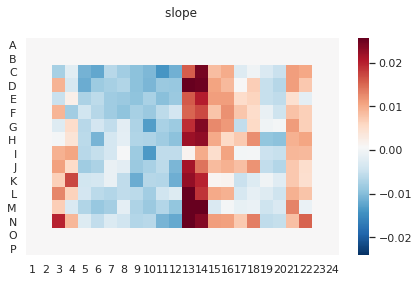

In [21]:
hts_heatmap(df = results, layout_path = layout_path, features = ['slope'], save_as = 'heatmap.png', path = path)


In [22]:
results = results[results.Status != 'Reference'].dropna().sort_values('Status')
print(results.shape)

(144, 55)



#### Calculate Statisctics
<a id="stat"></a>

In [23]:
block_0_stats = sum_statistics(results[results.Treatment == 'Block_0mM'], 'slope')
block_1_stats = sum_statistics(results[results.Treatment == 'Block_1mM'], 'slope')
display(block_0_stats, block_1_stats)

,Feature,Status,size,mean,std,var,Z_factor,SB
0,slope,Negative,24.0,0.008054,0.003828,0.000015,-1.487876,2.594475
1,slope,Positive,24.0,0.020897,0.006822,0.000047,-1.487876,2.594475
2,slope,Sample,24.0,0.008240,0.004231,0.000018,-1.487876,2.594475


,Feature,Status,size,mean,std,var,Z_factor,SB
0,slope,Negative,24.0,-0.008054,0.002815,0.000008,-1.383369,-0.603399
1,slope,Positive,24.0,0.004860,0.007445,0.000055,-1.383369,-0.603399
2,slope,Sample,24.0,-0.006669,0.002656,0.000007,-1.383369,-0.603399


### Plot results
<a id="viso"></a>

#### Pointplot
<a id="point"></a>

In [24]:
block_1 = results[results['Treatment'] == 'Block_1mM']
block_0 = results[results['Treatment'] == 'Block_0mM']

block 0um
pointplot_plate exception: 
bad operand type for unary -: 'list'


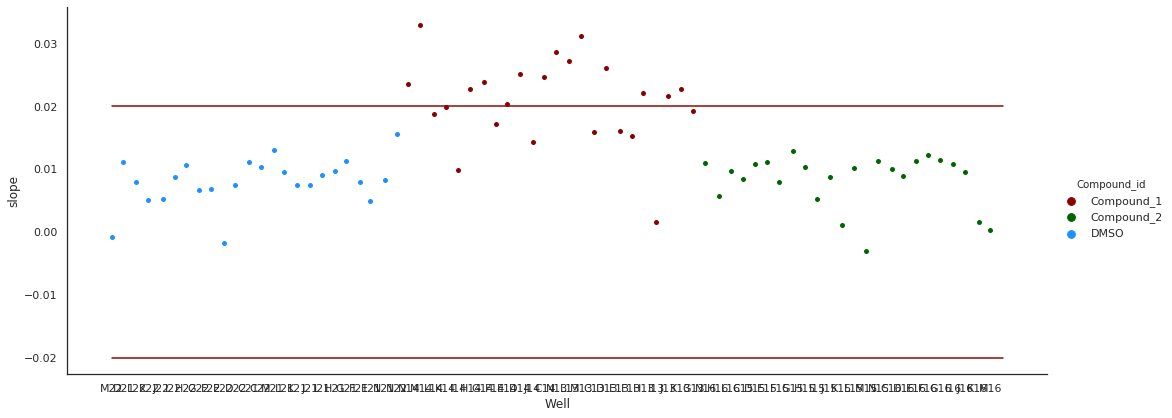

In [25]:
print('block 0um')
pointplot_plate(x = 'Well', y = 'slope', df = block_0, hue = 'Compound_id', hue_order = hue_order,
                   threshold = [-0.02, 0.02], ylabel = 'slope', palette = palette,  save_as = 'block_0_pointplot.png', path = path)

block 1um
pointplot_plate exception: 
bad operand type for unary -: 'list'


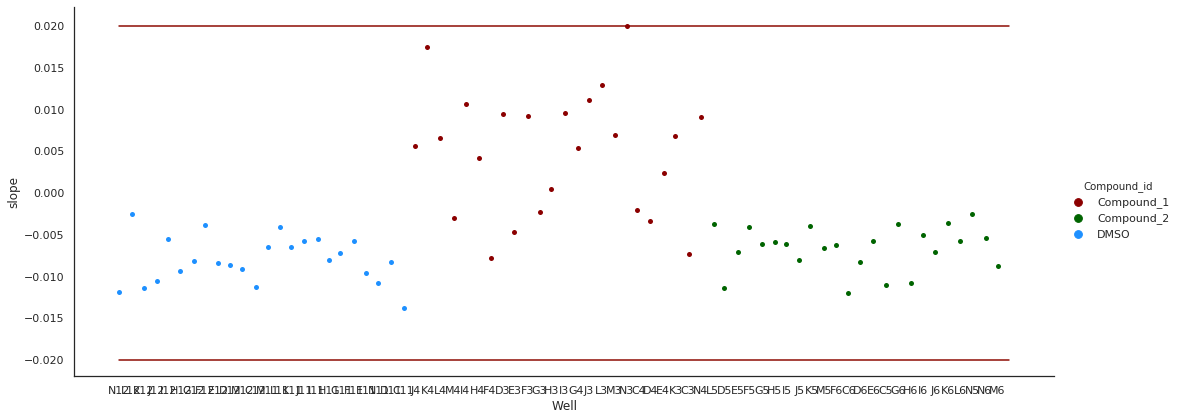

In [26]:
print('block 1um')
pointplot_plate(x = 'Well', y = 'slope', df = block_1, hue = 'Compound_id', hue_order = hue_order,
                   threshold = [-0.02, 0.02], ylabel = 'slope', palette = palette,  save_as = 'block_1_pointplot.png', path = path)

#### Plot treatments
<a id="violin"></a>

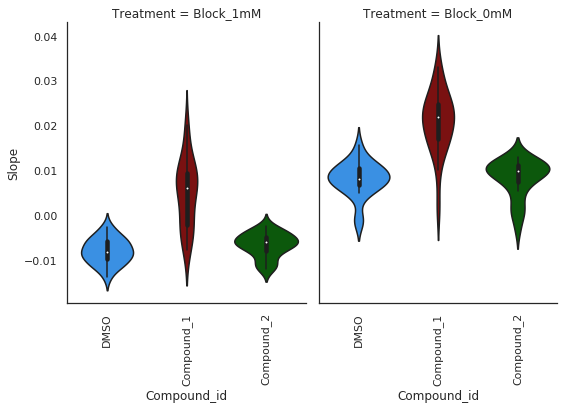

In [27]:
plot_treatments(results, x = 'Compound_id', y = 'slope', column = 'Treatment', kind = 'violin', 
                          ylabel = 'Slope', palette = palette, height = 5, aspect = 0.8, save_as = 'violin.png', path = path)

#### Create ppt report and clean output folder

In [28]:
report = create_presentation(path).save(path +'//' + 'ion_dev__report.pptx')

In [29]:
# Clean pictures from output folder
for f in os.listdir(path):
    if '.png' in f:
        os.remove(path +'//' + f)

### Conclusions
<a id="conclusions"></a>

* Addition of blocking agent doesn't improve statistics of the assay, as was proposed. 
* Compound_2 performs similar to the negative control (DMSO). 
* Compound_1, albeit shows positive dynamics, is not strong enough to serve as positive control as can be judged from Z-scores. 
* In this case, we need to search for better positive control and find a way to reduce variance in the assay.